# Predict Mobile App User Purchases
## Final ML Notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier

In [62]:
# Load features and labels
attr = pd.read_csv('features_attr3.csv')
attr = attr.fillna(0)
attr = attr.set_index('user_id')

In [63]:
events = pd.read_csv('features_events.csv').set_index('user_id')
events2 = pd.read_csv('features_events2.csv').set_index('user_id')
sessions = pd.read_csv('features_session_training6.0.csv')
sessions['user_id'] = sessions['id_']
sessions = sessions.drop(['id_'], axis=1).set_index('user_id')
labels14 = pd.read_csv('labels14.csv').set_index('user_id')
labels7 = pd.read_csv('labels7.csv').set_index('user_id')

In [19]:
# get user_id to hash dictionary
users = pd.read_csv('user_dict.csv', header=None)
inv_user_dict = {row[1][1]:row[1][0] for row in users.iterrows()}

In [64]:
# join data and prepare for modeling
data14 = labels14.join(events).join(events2).join(sessions).join(attr)
data7 = labels7.join(events).join(events2).join(sessions).join(attr)
y14 = data14['label']
X14 = data14.drop('label', axis=1)
y7 = data7['label']
X7 = data7.drop('label', axis=1)

In [65]:
# train test split
X14_train, X14_test, y14_train, y14_test = train_test_split(X14, y14, test_size=0.2, random_state=42)
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size=0.2, random_state=42)

In [66]:
X14_train=X14_train.fillna(0) 
X14_test=X14_test.fillna(0)
y14_train=y14_train.fillna(0)
y14_test=y14_test.fillna(0) 
X7_train=X7_train.fillna(0) 
X7_test=X7_test.fillna(0)
y7_train=y7_train.fillna(0)
y7_test=y7_test.fillna(0) 

## Model 1 - Random Forest

In [76]:
# {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}
rf7 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=50)
rf7.fit(X7_train, y7_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
false_positive_rate7, true_positive_rate7, thresholds7 = roc_curve(y7_test, rf7.predict_proba(X7_test)[:,1])
auc(false_positive_rate7, true_positive_rate7)

0.9743121514265147

In [78]:
rf14 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=50)
rf14.fit(X14_train, y14_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [79]:
false_positive_rate7, true_positive_rate7, thresholds7 = roc_curve(y14_test, rf14.predict_proba(X14_test)[:,1])
auc(false_positive_rate7, true_positive_rate7)

0.9674241364269447

In [115]:
# feature importance
feature_importances7 = pd.DataFrame(rf7.feature_importances_,
                                   index = X7_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)  
feature_importances14 = pd.DataFrame(rf14.feature_importances_,
                                   index = X14_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances14[:20] 

,importance
purchase_count_last_week,0.170781
e7_count_1_week,0.079123
purchase_sum_2_weeks,0.069298
purchase_count_total,0.058594
purchase_sum_last_week,0.054964
purchase_count_2_weeks,0.046689
e6_count_1_week,0.035899
attr_1,0.035733
purchase_sum_total,0.031850
attr_13,0.031586


In [118]:
# intersection of feature importance for 7 day and 14 day models
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
def union(a, b):
    """ return the union of two lists """
    return list(set(a) | set(b))
best_features = union(feature_importances7[:20].index, feature_importances14[:20].index)
best_features

['e7_count_2_week',
 'purchase_count_2_weeks',
 'attr_14',
 'total_count',
 'purchase_sum_2_weeks',
 'e4_count_1_week',
 'cr_from_now',
 'e41_count_1_week',
 'e3_count_1_week',
 'attr_7',
 'last2week_ss_duration',
 'e40_count_1_week',
 'e6_count_1_week',
 'purchase_sum_last_week',
 'e7_count_1_week',
 'purchase_count_last_week',
 'e5_count_1_week',
 'attr_5',
 'weekday_count',
 'purchase_count_total',
 'purchase_sum_total',
 'attr_13',
 'attr_1']

### Retrain model with top features only

In [119]:
X7_b = X7[best_features]
X14_b = X14[best_features]

In [120]:
X14_b_train, X14_b_test, y14_b_train, y14_b_test = train_test_split(X14_b, y14, test_size=0.2, random_state=42)
X7_b_train, X7_b_test, y7_b_train, y7_b_test = train_test_split(X7_b, y7, test_size=0.2, random_state=42)

In [121]:
X14_b_train=X14_b_train.fillna(0) 
X14_b_test=X14_b_test.fillna(0)
y14_b_train=y14_b_train.fillna(0)
y14_b_test=y14_b_test.fillna(0) 
X7_b_train=X7_b_train.fillna(0) 
X7_b_test=X7_b_test.fillna(0)
y7_b_train=y7_b_train.fillna(0)
y7_b_test=y7_b_test.fillna(0) 

In [124]:
# 7 day
rf7_b = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=20)
rf7_b.fit(X7_b_train, y7_b_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
false_positive_rate7, true_positive_rate7, thresholds7 = roc_curve(y7_b_test, rf7_b.predict_proba(X7_b_test)[:,1])
auc(false_positive_rate7, true_positive_rate7)

0.9750094799881919

In [133]:
# 14 day
rf14_b = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=20)
rf14_b.fit(X14_b_train, y14_b_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [134]:
false_positive_rate7, true_positive_rate7, thresholds7 = roc_curve(y14_b_test, rf14_b.predict_proba(X14_b_test)[:,1])
auc(false_positive_rate7, true_positive_rate7)

0.9670819912749714

## Model 2 - XGBoost

In [142]:
# 7 days
max_depth = 7
xgb7_b = XGBClassifier(max_depth=max_depth)
xgb7_b.fit(X7_b_train, y7_b_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [143]:
false_positive_rate7, true_positive_rate7, thresholds7 = roc_curve(y7_b_test, xgb7_b.predict_proba(X7_b_test)[:,1])
auc(false_positive_rate7, true_positive_rate7)

0.9758576968098629

In [144]:
# 14 day model
max_depth = 7
xgb14_b = XGBClassifier(max_depth=max_depth)
xgb14_b.fit(X14_b_train, y14_b_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [145]:
false_positive_rate7, true_positive_rate7, thresholds7 = roc_curve(y14_b_test, xgb14_b.predict_proba(X14_b_test)[:,1])
auc(false_positive_rate7, true_positive_rate7)

0.9683546365847155

## Model 3 - Stacking
 - Base models: rf, lr, xgb
 - Meta model: lr

In [147]:
# 7 days
train_pred_xgb7 = pd.DataFrame(xgb7_b.predict_proba(X7_b_train)[:,1])
test_pred_xgb7 = pd.DataFrame(xgb7_b.predict_proba(X7_b_test)[:,1])

In [148]:
train_pred_rf7 = pd.DataFrame(rf7_b.predict_proba(X7_b_train)[:,1])
test_pred_rf7 = pd.DataFrame(rf7_b.predict_proba(X7_b_test)[:,1])

In [149]:
df7 = pd.concat([train_pred_xgb7, train_pred_rf7], axis=1)
df_test7 = pd.concat([test_pred_xgb7, test_pred_rf7], axis=1)  # used for validation 

In [150]:
meta_model_7 = LogisticRegression()
meta_model_7.fit(df7,y7_b_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y7_b_test, meta_model_7.predict_proba(df_test7)[:,1])
auc(false_positive_rate, true_positive_rate)

/anaconda3/envs/MSDS694/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.976246199390785

In [152]:
# 14 days
train_pred_xgb14 = pd.DataFrame(xgb14_b.predict_proba(X14_b_train)[:,1])
test_pred_xgb14 = pd.DataFrame(xgb14_b.predict_proba(X14_b_test)[:,1])

In [153]:
train_pred_rf14 = pd.DataFrame(rf14_b.predict_proba(X14_b_train)[:,1])
test_pred_rf14 = pd.DataFrame(rf14_b.predict_proba(X14_b_test)[:,1])

In [154]:
df14 = pd.concat([train_pred_xgb14, train_pred_rf14], axis=1)
df_test14 = pd.concat([test_pred_xgb14, test_pred_rf14], axis=1)

In [155]:
meta_model_14 = LogisticRegression()
meta_model_14.fit(df14,y7_b_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y14_b_test, meta_model_14.predict_proba(df_test14)[:,1])
auc(false_positive_rate, true_positive_rate)

/anaconda3/envs/MSDS694/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9685742185668588

## Predict on full dataset for kaggle submission

In [156]:
attr_full = pd.read_csv('features_attr3_full.csv')
attr_full = attr_full.fillna(0)
attr_full = attr_full.set_index('user_id')

In [157]:
events_full = pd.read_csv('features_events_full.csv').set_index('user_id')
events2_full = pd.read_csv('features_events2_full.csv').set_index('user_id')

sessions_full = pd.read_csv('features_session_full6.0.csv')
sessions_full['user_id'] = sessions_full['id_']
sessions_full = sessions_full.drop(['id_'], axis=1)\
                .drop_duplicates()\
                .groupby('user_id', as_index=False)\
                .mean()\
                .set_index('user_id')

In [188]:
X_full = events_full.join(sessions_full, how='left').join(events2_full).join(attr_full)

In [189]:
X_ful l= X_full[best_features]

In [190]:
X_full = X_full.fillna(0) 

In [181]:
y7_pred = xgb7_b.predict_proba(X_full)
y14_pred = xgb14_b.predict_proba(X_full)

In [191]:
# Stacking model - create X_full
full_7_rf = pd.DataFrame(rf7_b.predict_proba(X_full)[:,1])
full_7_xgb = pd.DataFrame(xgb7_b.predict_proba(X_full)[:,1])
full_7 = pd.concat([full_7_rf, full_7_xgb], axis=1)

full_14_rf = pd.DataFrame(rf14_b.predict_proba(X_full)[:,1])
full_14_xgb = pd.DataFrame(xgb14_b.predict_proba(X_full)[:,1])
full_14 = pd.concat([full_14_rf, full_14_xgb], axis=1)

In [192]:
y14_pred = meta_model_14.predict_proba(full_7)
y7_pred = meta_model_7.predict_proba(full_14)

In [193]:
predictions = pd.DataFrame({'user_id_hash':X_full.index,
                            'user_purchase_binary_7_days':y7_pred[:,1],
                            'user_purchase_binary_14_days':y14_pred[:,1]})

In [194]:
# Map user_id back to user_id_hash for submission
predictions['user_id_hash'] = predictions['user_id_hash'].map(inv_user_dict)
predictions.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,dfa54ccdb64bddfc2ea6a1da90e3a908cd9250bddfd6a8...,0.001879,0.001879
1,c4d7c49762e7fdfac7eaba9975d26c4bc555cab68a3c94...,0.001887,0.001880
2,ffb2f6b4dba62a448604b775a14acce44cd7dd5af33ec7...,0.001906,0.001887
3,f9d94bf4c5e6f44ab3623f589dc406dd32eb9b712ddfad...,0.001879,0.001877
4,233442a2c9452f0301f9a7b280ef077064ab98b8c88623...,0.001873,0.001875


In [195]:
# Load sample submission df
samp_submission = pd.read_csv('sample_submission_2.csv')
samp_submission = samp_submission.rename(index=str, columns={"user_purchase_binary_7_days": "samp7",
                                                             "user_purchase_binary_14_days": "samp14"})
samp_submission.head()

,user_id_hash,samp7,samp14
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.01,0.02
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.01,0.02
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.01,0.02
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.01,0.02
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.01,0.02


In [197]:
# Create submission dataframe from predictions
submission = pd.merge(samp_submission, predictions, how='left', on='user_id_hash')
submission = submission.drop(columns=['samp7', 'samp14'])
submission.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.001875,0.001875
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.001874,0.001875
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.001876,0.001876
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.001888,0.001881
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.001873,0.001875


In [197]:
# Save to csv for submittal
submission.to_csv(path_or_buf='mar18_stacking.csv', index=False)

## Plot feature importance

In [228]:
pd14 = feature_importances14[:20]
pd7 = feature_importances7[:20]
pd14.to_csv("feature_imp_14days.csv", sep='\t', encoding='utf-8')
pd7.to_csv("feature_imp_7days.csv", sep='\t', encoding='utf-8')

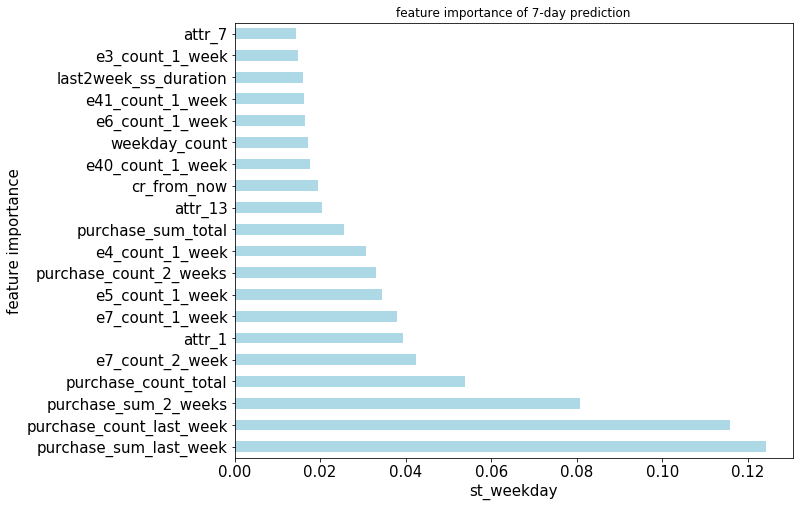

In [234]:
ax = pd7['importance'].plot(kind='barh',
                                    figsize=(10,8),
                                    title="feature importance of 7-day prediction", color='lightblue')
ax.set_xlabel("st_weekday", fontsize =15)
ax.set_ylabel("feature importance", fontsize=15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

fig = ax.get_figure()
fig.savefig('7-day_fimp.png')

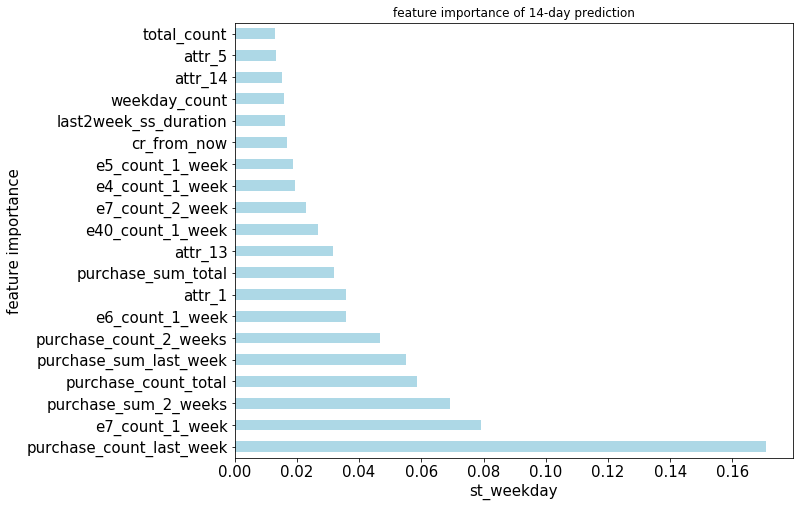

In [232]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = pd14['importance'].plot(kind='barh',
                                    figsize=(10,8),
                                    title="feature importance of 14-day prediction", color='lightblue')
ax.set_xlabel("st_weekday", fontsize =15)
ax.set_ylabel("feature importance", fontsize=15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

fig = ax.get_figure()
fig.savefig('14-day_fimp.png')